### Structure matrix (Precision matrix)

In [2]:
import contextily
import geopandas
import rioxarray
import seaborn
import pandas
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry

Creating the square geospatial dataframe

In [3]:
# Get points in a grid
l = numpy.arange(3)
xs, ys = numpy.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)

In [4]:
gdf

,geometry,id
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",P-00
1,"POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....",P-01
2,"POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....",P-02
3,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",P-03
4,"POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....",P-04
5,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",P-05
6,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",P-06
7,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",P-07
8,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",P-08


#### Rook contiguity matrix

In [5]:
from pysal.lib import weights

# Build a rook contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wr = weights.contiguity.Rook.from_dataframe(gdf)

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_16951/4157747266.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wr = weights.contiguity.Rook.from_dataframe(gdf)


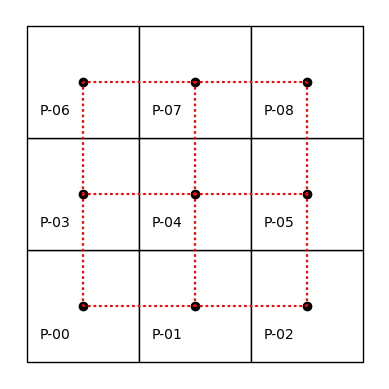

In [10]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

In [15]:
# if there are islands this results need to be checked
neighbors = wr.neighbors

In [16]:
neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

In [36]:
Q_r = pandas.DataFrame(*wr.full()).astype(int)

In [37]:
Q_r

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


In [38]:
# Iterate over the dictionary
for key, value in neighbors.items():
    count = len(value)
    Q_r[key][key] = count  # Fill the diagonal with count

In [39]:
Q_r.index = gdf["id"].values

In [40]:
Q_r

,0,1,2,3,4,5,6,7,8
P-00,2,1,0,1,0,0,0,0,0
P-01,1,3,1,0,1,0,0,0,0
P-02,0,1,2,0,0,1,0,0,0
P-03,1,0,0,3,1,0,1,0,0
P-04,0,1,0,1,4,1,0,1,0
P-05,0,0,1,0,1,3,0,0,1
P-06,0,0,0,1,0,0,2,1,0
P-07,0,0,0,0,1,0,1,3,1
P-08,0,0,0,0,0,1,0,1,2


#### Queen contiguity matrix


In [43]:
# Build a queen contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wq = weights.contiguity.Queen.from_dataframe(gdf)
neighbors_q = wq.neighbors

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_16951/1655934425.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = weights.contiguity.Queen.from_dataframe(gdf)


In [44]:
neighbors_q

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

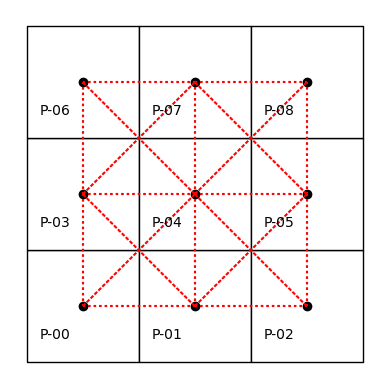

In [35]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

In [41]:
Q_q = pandas.DataFrame(*wq.full()).astype(int)

In [42]:
Q_q

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,1,0,0,0,0
1,1,0,1,1,1,1,0,0,0
2,0,1,0,0,1,1,0,0,0
3,1,1,0,0,1,0,1,1,0
4,1,1,1,1,0,1,1,1,1
5,0,1,1,0,1,0,0,1,1
6,0,0,0,1,1,0,0,1,0
7,0,0,0,1,1,1,1,0,1
8,0,0,0,0,1,1,0,1,0


In [45]:
# Iterate over the dictionary
for key, value in neighbors_q.items():
    count = len(value)
    Q_q[key][key] = count  # Fill the diagonal with count

In [46]:
Q_q

,0,1,2,3,4,5,6,7,8
0,3,1,0,1,1,0,0,0,0
1,1,5,1,1,1,1,0,0,0
2,0,1,3,0,1,1,0,0,0
3,1,1,0,5,1,0,1,1,0
4,1,1,1,1,8,1,1,1,1
5,0,1,1,0,1,5,0,1,1
6,0,0,0,1,1,0,3,1,0
7,0,0,0,1,1,1,1,5,1
8,0,0,0,0,1,1,0,1,3
